# 07 - Gold Error Analysis

This notebook performs full gold-set error analysis for Phase 3:

1. Selects the **best Task 1 run** by macro F1 on `data/silver/dev.json`.
2. Loads `data/gold/gold_test.json`.
3. Runs inference on all gold sentences.
4. Computes per-entity metrics on gold.
5. Categorizes errors into:
   - a) Boundary
   - b) Type confusion
   - c) Missed entities (FN)
   - d) Hallucinated entities (FP)
   - e) Morphological errors (Arabic-specific)
6. Produces counts, examples, summary table, hardest sentences, and visualizations.


In [1]:
from __future__ import annotations

import json
import re
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import Dataset
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
)

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_colwidth", 180)


In [2]:
def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "data").exists() and (candidate / "models").exists():
            return candidate
    return start


PROJECT_ROOT = find_project_root(Path.cwd())
SILVER_DEV_PATH = PROJECT_ROOT / "data" / "silver" / "dev.json"
GOLD_TEST_PATH = PROJECT_ROOT / "data" / "gold" / "gold_test.json"

RUN_MODELS = {
    "Run A (AraBERT standard)": PROJECT_ROOT / "models" / "islamic_ner_standard" / "final_model",
    "Run B (AraBERT weighted)": PROJECT_ROOT / "models" / "islamic_ner_weighted" / "final_model",
}

ENTITY_TYPES = ["SCHOLAR", "BOOK", "CONCEPT", "PLACE", "HADITH_REF"]
LABELS = [
    "O",
    "B-SCHOLAR", "I-SCHOLAR",
    "B-BOOK", "I-BOOK",
    "B-CONCEPT", "I-CONCEPT",
    "B-PLACE", "I-PLACE",
    "B-HADITH_REF", "I-HADITH_REF",
]
LABEL2ID = {label: i for i, label in enumerate(LABELS)}
ID2LABEL = {i: label for label, i in LABEL2ID.items()}

MAX_SEQ_LENGTH = 512
SEED = 42

assert SILVER_DEV_PATH.exists(), f"Missing file: {SILVER_DEV_PATH}"
assert GOLD_TEST_PATH.exists(), f"Missing file: {GOLD_TEST_PATH}"
for run_name, run_path in RUN_MODELS.items():
    assert run_path.exists(), f"Missing model for {run_name}: {run_path}"

print("Project root:", PROJECT_ROOT)
print("Silver dev:", SILVER_DEV_PATH)
print("Gold test:", GOLD_TEST_PATH)
for k, v in RUN_MODELS.items():
    print(f"{k}: {v}")


Project root: c:\Users\diaab\islamic-ner
Silver dev: c:\Users\diaab\islamic-ner\data\silver\dev.json
Gold test: c:\Users\diaab\islamic-ner\data\gold\gold_test.json
Run A (AraBERT standard): c:\Users\diaab\islamic-ner\models\islamic_ner_standard\final_model
Run B (AraBERT weighted): c:\Users\diaab\islamic-ner\models\islamic_ner_weighted\final_model


In [3]:
def load_records(path: Path) -> List[Dict]:
    payload = json.loads(path.read_text(encoding="utf-8"))
    if not isinstance(payload, list):
        raise ValueError(f"Expected list JSON in {path}")

    cleaned = []
    for i, row in enumerate(payload):
        tokens = row.get("tokens") or []
        tags = row.get("ner_tags") or []
        if not isinstance(tokens, list) or not isinstance(tags, list):
            continue
        n = min(len(tokens), len(tags))
        if n == 0:
            continue
        cleaned.append(
            {
                "id": str(row.get("id", f"{path.stem}_{i}")),
                "tokens": [str(t) for t in tokens[:n]],
                "ner_tags": [str(t) for t in tags[:n]],
            }
        )
    return cleaned


def tokenize_and_align_labels(examples, tokenizer):
    tokenized = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=MAX_SEQ_LENGTH,
    )

    aligned = []
    for i, word_tags in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        prev_word = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != prev_word:
                label_ids.append(LABEL2ID[word_tags[word_idx]])
            else:
                label_ids.append(-100)
            prev_word = word_idx
        aligned.append(label_ids)

    tokenized["labels"] = aligned
    return tokenized


def decode_predictions(pred_ids: np.ndarray, label_ids: np.ndarray) -> Tuple[List[List[str]], List[List[str]]]:
    y_true = []
    y_pred = []

    for pred_row, label_row in zip(pred_ids, label_ids):
        row_true = []
        row_pred = []
        for pred_id, label_id in zip(pred_row, label_row):
            if int(label_id) == -100:
                continue
            row_true.append(ID2LABEL[int(label_id)])
            row_pred.append(ID2LABEL[int(pred_id)])
        y_true.append(row_true)
        y_pred.append(row_pred)

    return y_true, y_pred


def run_inference(model_dir: Path, records: List[Dict], split_name: str) -> Dict:
    dataset = Dataset.from_list(records)

    tokenizer = AutoTokenizer.from_pretrained(str(model_dir), local_files_only=True)
    model = AutoModelForTokenClassification.from_pretrained(str(model_dir), local_files_only=True)

    tokenized = dataset.map(
        lambda x: tokenize_and_align_labels(x, tokenizer),
        batched=True,
        remove_columns=dataset.column_names,
        desc=f"Tokenize {split_name}",
    )

    args = TrainingArguments(
        output_dir=str(PROJECT_ROOT / "models" / "_tmp_error_analysis" / split_name),
        per_device_eval_batch_size=16,
        report_to="none",
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=args,
        eval_dataset=tokenized,
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer=tokenizer),
    )

    pred_output = trainer.predict(tokenized)
    pred_ids = np.argmax(pred_output.predictions, axis=2)
    y_true, y_pred = decode_predictions(pred_ids, pred_output.label_ids)

    sentence_ids = []
    sentence_tokens = []
    truncation_count = 0
    for i, row in enumerate(dataset):
        kept = len(y_true[i])
        sentence_ids.append(row["id"])
        sentence_tokens.append(row["tokens"][:kept])
        if kept < len(row["tokens"]):
            truncation_count += 1

    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "sentence_ids": sentence_ids,
        "sentence_tokens": sentence_tokens,
        "truncation_count": truncation_count,
    }


def macro_f1_from_sequences(y_true: List[List[str]], y_pred: List[List[str]]) -> float:
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    macro = report.get("macro avg", {})
    return float(macro.get("f1-score", 0.0))


In [4]:
# Step 1: Pick best Task 1 run by macro F1 on silver dev.
silver_dev_records = load_records(SILVER_DEV_PATH)
print(f"Silver dev records: {len(silver_dev_records)}")

run_rows = []
run_eval_cache = {}

for run_name, model_dir in RUN_MODELS.items():
    out = run_inference(model_dir, silver_dev_records, split_name=f"silver_dev_{run_name.replace(' ', '_')}")
    macro_f1 = macro_f1_from_sequences(out["y_true"], out["y_pred"])
    overall_f1 = float(f1_score(out["y_true"], out["y_pred"], zero_division=0))
    run_rows.append(
        {
            "run": run_name,
            "macro_f1": macro_f1,
            "overall_f1": overall_f1,
        }
    )
    run_eval_cache[run_name] = out

run_scores_df = pd.DataFrame(run_rows).sort_values(["macro_f1", "overall_f1"], ascending=False).reset_index(drop=True)
display(run_scores_df)

BEST_RUN = run_scores_df.iloc[0]["run"]
BEST_MODEL_DIR = RUN_MODELS[BEST_RUN]
print(f"Selected best run: {BEST_RUN}")
print(f"Model path: {BEST_MODEL_DIR}")


Silver dev records: 360


Tokenize silver_dev_Run_A_(AraBERT_standard):   0%|          | 0/360 [00:00<?, ? examples/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


  0%|          | 0/23 [00:00<?, ?it/s]

Tokenize silver_dev_Run_B_(AraBERT_weighted):   0%|          | 0/360 [00:00<?, ? examples/s]

  0%|          | 0/23 [00:00<?, ?it/s]

,run,macro_f1,overall_f1
0,Run A (AraBERT standard),0.705434,0.935018
1,Run B (AraBERT weighted),0.674814,0.869887


Selected best run: Run A (AraBERT standard)
Model path: c:\Users\diaab\islamic-ner\models\islamic_ner_standard\final_model


In [5]:
# Step 2-3: Load gold set and run inference with best model on all sentences.
gold_records = load_records(GOLD_TEST_PATH)
print(f"Gold records loaded: {len(gold_records)}")
assert len(gold_records) == 200, "Expected exactly 200 gold sentences."

gold_out = run_inference(BEST_MODEL_DIR, gold_records, split_name="gold_test_best_run")
print("Gold inference complete.")
print("Truncated sentences (if any):", gold_out["truncation_count"])


Gold records loaded: 200


Tokenize gold_test_best_run:   0%|          | 0/200 [00:00<?, ? examples/s]

C:\Users\diaab\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


  0%|          | 0/13 [00:00<?, ?it/s]

Gold inference complete.
Truncated sentences (if any): 18


In [6]:
# Step 4: Per-entity metrics on gold data.
gold_report = classification_report(gold_out["y_true"], gold_out["y_pred"], output_dict=True, zero_division=0)

overall_gold = {
    "precision": float(precision_score(gold_out["y_true"], gold_out["y_pred"], zero_division=0)),
    "recall": float(recall_score(gold_out["y_true"], gold_out["y_pred"], zero_division=0)),
    "f1": float(f1_score(gold_out["y_true"], gold_out["y_pred"], zero_division=0)),
    "macro_f1": float(gold_report.get("macro avg", {}).get("f1-score", 0.0)),
}

entity_rows = []
for entity in ENTITY_TYPES:
    row = gold_report.get(entity, {})
    entity_rows.append(
        {
            "entity": entity,
            "precision": float(row.get("precision", float("nan"))),
            "recall": float(row.get("recall", float("nan"))),
            "f1": float(row.get("f1-score", float("nan"))),
            "support": int(row.get("support", 0)) if isinstance(row.get("support", 0), (int, float)) else 0,
        }
    )

entity_metrics_df = pd.DataFrame(entity_rows).sort_values("f1", ascending=False, na_position="last")
print("Overall gold metrics:")
display(pd.DataFrame([overall_gold]))
print("Per-entity gold metrics:")
display(entity_metrics_df)


Overall gold metrics:


,precision,recall,f1,macro_f1
0,0.895229,0.928225,0.911429,0.733714


Per-entity gold metrics:


,entity,precision,recall,f1,support
2,CONCEPT,0.965517,0.965517,0.965517,0
0,SCHOLAR,0.912731,0.926042,0.919338,0
4,HADITH_REF,0.500000,0.750000,0.600000,0
3,PLACE,0.290323,1.000000,0.450000,0
1,BOOK,NaN,NaN,NaN,0


In [7]:
# Step 5: Error taxonomy utilities.
DIACRITIC_RE = re.compile(r"[ؐ-ًؚ-ٰٟۖ-ۭ]")
ARABIC_LETTER_RE = re.compile(r"^[ء-ي]+$")

CATEGORY_LABELS = {
    "a_boundary": "a) Boundary errors",
    "b_type_confusion": "b) Type confusion",
    "c_missed": "c) Missed entities (FN)",
    "d_hallucinated": "d) Hallucinated entities (FP)",
    "e_morphological": "e) Morphological errors",
}
CATEGORY_ORDER = [
    "a_boundary",
    "b_type_confusion",
    "c_missed",
    "d_hallucinated",
    "e_morphological",
]


def tag_to_type(tag: str) -> str:
    if tag == "O":
        return "O"
    if "-" not in tag:
        return "O"
    return tag.split("-", 1)[1]


def bio_to_spans(tags: List[str], tokens: List[str]) -> List[Dict]:
    spans = []
    start = None
    current_type = None

    extended_tags = list(tags) + ["O"]
    for i, tag in enumerate(extended_tags):
        if tag == "O" or "-" not in tag:
            if current_type is not None:
                spans.append(
                    {
                        "start": start,
                        "end": i,
                        "label": current_type,
                        "text": " ".join(tokens[start:i]),
                    }
                )
                start = None
                current_type = None
            continue

        prefix, ent_type = tag.split("-", 1)

        if prefix == "B":
            if current_type is not None:
                spans.append(
                    {
                        "start": start,
                        "end": i,
                        "label": current_type,
                        "text": " ".join(tokens[start:i]),
                    }
                )
            start = i
            current_type = ent_type
        elif prefix == "I":
            if current_type == ent_type:
                continue
            # Broken BIO continuation: close prior span and open a new span.
            if current_type is not None:
                spans.append(
                    {
                        "start": start,
                        "end": i,
                        "label": current_type,
                        "text": " ".join(tokens[start:i]),
                    }
                )
            start = i
            current_type = ent_type

    return spans


def overlap_len(a: Dict, b: Dict) -> int:
    left = max(a["start"], b["start"])
    right = min(a["end"], b["end"])
    return max(0, right - left)


def boundary_subtype(gold_span: Dict, pred_span: Dict) -> str:
    g0, g1 = gold_span["start"], gold_span["end"]
    p0, p1 = pred_span["start"], pred_span["end"]
    if p0 <= g0 and p1 >= g1 and (p0 < g0 or p1 > g1):
        return "over-extension"
    if g0 <= p0 and g1 >= p1 and (g0 < p0 or g1 > p1):
        return "under-extension"
    return "partial-boundary-overlap"


def detect_morph_subtype(tokens: List[str], start: int, end: int, text: str) -> str | None:
    window = tokens[max(0, start - 1): min(len(tokens), end + 1)]
    has_diacritic = bool(DIACRITIC_RE.search(text))

    # Heuristic agglutination check (common Arabic clitics attached to stem).
    has_agglut = False
    for tok in window:
        t = tok.strip()
        if not t:
            continue
        if ARABIC_LETTER_RE.match(t):
            if any(t.startswith(pref) and len(t) > len(pref) + 1 for pref in ("???", "???", "???", "???", "??", "??", "??")):
                has_agglut = True
                break
            if t[0] in {"?", "?", "?", "?", "?"} and len(t) >= 4:
                has_agglut = True
                break

    if has_agglut and has_diacritic:
        return "agglutination+diacritic"
    if has_agglut:
        return "agglutination"
    if has_diacritic:
        return "diacritic-sensitivity"
    return None


def infer_missed_reason(span: Dict, support_by_entity: Dict[str, int], morph_subtype: str | None) -> str:
    label = span["label"]
    text = span["text"]

    if morph_subtype == "diacritic-sensitivity":
        return "Likely diacritic/tashkeel variant mismatch."
    if morph_subtype and "agglutination" in morph_subtype:
        return "Likely clitic/agglutination handling issue around entity boundary."
    if support_by_entity.get(label, 0) < 20:
        return "Very low-support entity type in gold data."
    if label == "SCHOLAR" and len(text.split()) >= 3:
        return "Long multi-token scholar name; boundary/context ambiguity."
    if any(ch.isdigit() for ch in text):
        return "Citation/number pattern ambiguity."
    return "Ambiguous context or unseen lexical form."


def infer_hallucination_reason(span: Dict, morph_subtype: str | None) -> str:
    label = span["label"]

    if morph_subtype == "diacritic-sensitivity":
        return "Potential diacritic normalization mismatch."
    if morph_subtype and "agglutination" in morph_subtype:
        return "Potential clitic/agglutination split error."
    if label == "CONCEPT":
        return "Common noun/religious wording over-generalized as CONCEPT."
    if label == "SCHOLAR":
        return "Name-like token pattern over-generalized as SCHOLAR."
    return "Context ambiguity causing false positive entity trigger."


In [8]:
def categorize_sentence_errors(
    tokens: List[str],
    gold_tags: List[str],
    pred_tags: List[str],
    support_by_entity: Dict[str, int],
) -> List[Dict]:
    gold_spans = bio_to_spans(gold_tags, tokens)
    pred_spans = bio_to_spans(pred_tags, tokens)

    events = []
    used_gold = set()
    used_pred = set()

    # Exact matches are not errors.
    for gi, g in enumerate(gold_spans):
        for pi, p in enumerate(pred_spans):
            if pi in used_pred:
                continue
            if g["start"] == p["start"] and g["end"] == p["end"] and g["label"] == p["label"]:
                used_gold.add(gi)
                used_pred.add(pi)
                break

    # Type confusion: overlap exists but predicted type differs.
    for gi, g in enumerate(gold_spans):
        if gi in used_gold:
            continue

        best = None
        for pi, p in enumerate(pred_spans):
            if pi in used_pred:
                continue
            ov = overlap_len(g, p)
            if ov <= 0:
                continue
            if p["label"] == g["label"]:
                continue
            score = (ov, -abs((g["end"] - g["start"]) - (p["end"] - p["start"])))
            if best is None or score > best[0]:
                best = (score, pi, p)

        if best is not None:
            _, pi, p = best
            used_gold.add(gi)
            used_pred.add(pi)
            events.append(
                {
                    "category": "b_type_confusion",
                    "subtype": f"{g['label']} -> {p['label']}",
                    "affected_entity": g["label"],
                    "gold_entity": g["label"],
                    "pred_entity": p["label"],
                    "gold_span": g["text"],
                    "pred_span": p["text"],
                    "reason": "Overlapping entity span predicted with wrong type.",
                }
            )

    # Boundary errors: same type and overlap, but boundaries mismatch.
    for gi, g in enumerate(gold_spans):
        if gi in used_gold:
            continue

        best = None
        for pi, p in enumerate(pred_spans):
            if pi in used_pred:
                continue
            ov = overlap_len(g, p)
            if ov <= 0:
                continue
            if p["label"] != g["label"]:
                continue
            if p["start"] == g["start"] and p["end"] == g["end"]:
                continue
            score = (ov, -abs((g["end"] - g["start"]) - (p["end"] - p["start"])))
            if best is None or score > best[0]:
                best = (score, pi, p)

        if best is not None:
            _, pi, p = best
            used_gold.add(gi)
            used_pred.add(pi)
            events.append(
                {
                    "category": "a_boundary",
                    "subtype": boundary_subtype(g, p),
                    "affected_entity": g["label"],
                    "gold_entity": g["label"],
                    "pred_entity": p["label"],
                    "gold_span": g["text"],
                    "pred_span": p["text"],
                    "reason": "Entity type correct, but boundaries do not match exactly.",
                }
            )

    # Remaining unmatched gold spans: missed entities (or morphological).
    for gi, g in enumerate(gold_spans):
        if gi in used_gold:
            continue

        morph = detect_morph_subtype(tokens, g["start"], g["end"], g["text"])
        category = "e_morphological" if morph else "c_missed"
        subtype = f"missed-{morph}" if morph else f"missed-{g['label']}"
        events.append(
            {
                "category": category,
                "subtype": subtype,
                "affected_entity": g["label"],
                "gold_entity": g["label"],
                "pred_entity": "O",
                "gold_span": g["text"],
                "pred_span": "",
                "reason": infer_missed_reason(g, support_by_entity, morph),
            }
        )

    # Remaining unmatched predicted spans: hallucinations (or morphological).
    for pi, p in enumerate(pred_spans):
        if pi in used_pred:
            continue

        morph = detect_morph_subtype(tokens, p["start"], p["end"], p["text"])
        category = "e_morphological" if morph else "d_hallucinated"
        subtype = f"hallucinated-{morph}" if morph else f"hallucinated-{p['label']}"
        events.append(
            {
                "category": category,
                "subtype": subtype,
                "affected_entity": p["label"],
                "gold_entity": "O",
                "pred_entity": p["label"],
                "gold_span": "",
                "pred_span": p["text"],
                "reason": infer_hallucination_reason(p, morph),
            }
        )

    return events


# Build error list for all 200 gold sentences.
entity_support = {
    entity: int(gold_report.get(entity, {}).get("support", 0))
    for entity in ENTITY_TYPES
}

all_errors = []
for idx, (sid, tokens, g_tags, p_tags) in enumerate(
    zip(
        gold_out["sentence_ids"],
        gold_out["sentence_tokens"],
        gold_out["y_true"],
        gold_out["y_pred"],
    )
):
    sentence_events = categorize_sentence_errors(tokens, g_tags, p_tags, entity_support)
    sent_text = " ".join(tokens)
    for ev in sentence_events:
        ev["sentence_id"] = sid
        ev["sentence_index"] = idx
        ev["sentence_text"] = sent_text
    all_errors.extend(sentence_events)

errors_df = pd.DataFrame(all_errors)
print(f"Total errors found: {len(errors_df)}")
display(errors_df.head(10))


Total errors found: 141


,category,subtype,affected_entity,gold_entity,pred_entity,gold_span,pred_span,reason,sentence_id,sentence_index,sentence_text
0,a_boundary,over-extension,SCHOLAR,SCHOLAR,SCHOLAR,محمد بن سهل بن ابي,محمد بن سهل بن ابي حثمه,"Entity type correct, but boundaries do not match exactly.",sanadset_43179,1,"اخبرنا محمد بن عمر ، حدثني موسي بن عمر الحارثي ، عن محمد بن سهل بن ابي حثمه ، قال : "" كانت صدقه رسول الله صلي الله عليه وسلم من اموال بني النضير ، وهي سبعه : الاعواف والصافيه و..."
1,d_hallucinated,hallucinated-SCHOLAR,SCHOLAR,O,SCHOLAR,,موسي بن عمر الحارثي,Name-like token pattern over-generalized as SCHOLAR.,sanadset_43179,1,"اخبرنا محمد بن عمر ، حدثني موسي بن عمر الحارثي ، عن محمد بن سهل بن ابي حثمه ، قال : "" كانت صدقه رسول الله صلي الله عليه وسلم من اموال بني النضير ، وهي سبعه : الاعواف والصافيه و..."
2,a_boundary,over-extension,SCHOLAR,SCHOLAR,SCHOLAR,معاويه,معاويه بن ابي سفيان,"Entity type correct, but boundaries do not match exactly.",sanadset_30525,3,"حدثنا سفيان ، قال : حدثنا طلحه بن يحيي ، عن عمه عيسي بن طلحه , انه سمع معاويه بن ابي سفيان ، يقول : سمعت رسول الله صلي الله عليه وسلم ، يقول : "" اذا قال المؤذن : الله اكبر , ال..."
3,d_hallucinated,hallucinated-SCHOLAR,SCHOLAR,O,SCHOLAR,,عمه,Name-like token pattern over-generalized as SCHOLAR.,sanadset_30525,3,"حدثنا سفيان ، قال : حدثنا طلحه بن يحيي ، عن عمه عيسي بن طلحه , انه سمع معاويه بن ابي سفيان ، يقول : سمعت رسول الله صلي الله عليه وسلم ، يقول : "" اذا قال المؤذن : الله اكبر , ال..."
4,a_boundary,under-extension,SCHOLAR,SCHOLAR,SCHOLAR,من اهل الدنيا يتكلم,من اهل الدنيا,"Entity type correct, but boundaries do not match exactly.",sanadset_48745,4,"اخبرنا اخبرنا عبد الله بن بكر السهمي ، قال : حدثنا حاتم بن ابي صغيره ، عن سماك بن حرب : "" ان معاويه استعمل النعمان بن بشير علي الكوفه ، وكان والله من اخطب من سمعت من اهل الدنيا..."
5,c_missed,missed-SCHOLAR,SCHOLAR,SCHOLAR,O,النعمان بن بشير,,Long multi-token scholar name; boundary/context ambiguity.,sanadset_48745,4,"اخبرنا اخبرنا عبد الله بن بكر السهمي ، قال : حدثنا حاتم بن ابي صغيره ، عن سماك بن حرب : "" ان معاويه استعمل النعمان بن بشير علي الكوفه ، وكان والله من اخطب من سمعت من اهل الدنيا..."
6,a_boundary,over-extension,SCHOLAR,SCHOLAR,SCHOLAR,عمر,عمر بن الخطاب,"Entity type correct, but boundaries do not match exactly.",sanadset_19892,8,"قال الشافعي رحمه الله تعالي : اخبرنا قال الشافعي رحمه الله تعالي : اخبرنا مالك , عن زيد بن اسلم , عن مسلم بن جندب , عن اسلم , مولي عمر بن الخطاب , ان عمر قضي في الضرس بجمل , وف..."
7,d_hallucinated,hallucinated-SCHOLAR,SCHOLAR,O,SCHOLAR,,عمر,Name-like token pattern over-generalized as SCHOLAR.,sanadset_18424,9,"اخبرنا سفيان ، عن ايوب ، عن نافع ، عن ابن عمر ، ان عمر "" نذر ان يعتكف في الجاهليه ، فسال النبي صلي الله عليه وسلم ، فامره ان يعتكف في الاسلام "" . ."
8,a_boundary,under-extension,SCHOLAR,SCHOLAR,SCHOLAR,محمد بن يوسف,محمد,"Entity type correct, but boundaries do not match exactly.",hadith_json_5229,10,وقال محمد بن يوسف عن سفيان، عن منصور ابن صفيه، حدثتني امي، عن عائشه رضي الله عنها قالت توفي رسول الله صلي الله عليه وسلم وقد شبعنا من الاسودين التمر والماء‏.‏
9,c_missed,missed-SCHOLAR,SCHOLAR,SCHOLAR,O,عباده بن الصامت,,Long multi-token scholar name; boundary/context ambiguity.,hadith_json_18,11,حدثنا ابو اليمان، قال اخبرنا شعيب، عن الزهري، قال اخبرني ابو ادريس، عائذ الله بن عبد الله ان عباده بن الصامت رضي الله عنه وكان شهد بدرا، وهو احد النقباء ليله العقبه ان رسول الل...


In [9]:
# Step 6 (part 1): Error counts + summary table.
count_map = errors_df["category"].value_counts().to_dict() if not errors_df.empty else {}

summary_rows = []
total_errors = int(len(errors_df))

for cat in CATEGORY_ORDER:
    subset = errors_df[errors_df["category"] == cat] if not errors_df.empty else pd.DataFrame()
    count = int(len(subset))
    pct = (count / total_errors * 100.0) if total_errors else 0.0
    most_entity = "-"
    if count:
        mode_vals = subset["affected_entity"].dropna().astype(str).mode()
        if not mode_vals.empty:
            most_entity = mode_vals.iloc[0]

    summary_rows.append(
        {
            "Error Type": CATEGORY_LABELS[cat],
            "Count": count,
            "% of Total Errors": round(pct, 2),
            "Most Affected Entity": most_entity,
        }
    )

summary_df = pd.DataFrame(summary_rows)
print("Error count per category:")
for cat in CATEGORY_ORDER:
    print(f"- {CATEGORY_LABELS[cat]}: {count_map.get(cat, 0)}")

print("\nSummary table:")
display(summary_df)


Error count per category:
- a) Boundary errors: 44
- b) Type confusion: 1
- c) Missed entities (FN): 29
- d) Hallucinated entities (FP): 67
- e) Morphological errors: 0

Summary table:


,Error Type,Count,% of Total Errors,Most Affected Entity
0,a) Boundary errors,44,31.21,SCHOLAR
1,b) Type confusion,1,0.71,SCHOLAR
2,c) Missed entities (FN),29,20.57,SCHOLAR
3,d) Hallucinated entities (FP),67,47.52,SCHOLAR
4,e) Morphological errors,0,0.00,-


In [10]:
# Step 6 (part 2): 5 example errors for each category.
example_cols = [
    "sentence_id",
    "subtype",
    "gold_entity",
    "pred_entity",
    "gold_span",
    "pred_span",
    "reason",
    "sentence_text",
]

for cat in CATEGORY_ORDER:
    print("\n" + "=" * 120)
    print(CATEGORY_LABELS[cat])
    print("=" * 120)

    subset = errors_df[errors_df["category"] == cat].head(5)
    if subset.empty:
        print("No examples for this category.")
    else:
        display(subset[example_cols])



a) Boundary errors


,sentence_id,subtype,gold_entity,pred_entity,gold_span,pred_span,reason,sentence_text
0,sanadset_43179,over-extension,SCHOLAR,SCHOLAR,محمد بن سهل بن ابي,محمد بن سهل بن ابي حثمه,"Entity type correct, but boundaries do not match exactly.","اخبرنا محمد بن عمر ، حدثني موسي بن عمر الحارثي ، عن محمد بن سهل بن ابي حثمه ، قال : "" كانت صدقه رسول الله صلي الله عليه وسلم من اموال بني النضير ، وهي سبعه : الاعواف والصافيه و..."
2,sanadset_30525,over-extension,SCHOLAR,SCHOLAR,معاويه,معاويه بن ابي سفيان,"Entity type correct, but boundaries do not match exactly.","حدثنا سفيان ، قال : حدثنا طلحه بن يحيي ، عن عمه عيسي بن طلحه , انه سمع معاويه بن ابي سفيان ، يقول : سمعت رسول الله صلي الله عليه وسلم ، يقول : "" اذا قال المؤذن : الله اكبر , ال..."
4,sanadset_48745,under-extension,SCHOLAR,SCHOLAR,من اهل الدنيا يتكلم,من اهل الدنيا,"Entity type correct, but boundaries do not match exactly.","اخبرنا اخبرنا عبد الله بن بكر السهمي ، قال : حدثنا حاتم بن ابي صغيره ، عن سماك بن حرب : "" ان معاويه استعمل النعمان بن بشير علي الكوفه ، وكان والله من اخطب من سمعت من اهل الدنيا..."
6,sanadset_19892,over-extension,SCHOLAR,SCHOLAR,عمر,عمر بن الخطاب,"Entity type correct, but boundaries do not match exactly.","قال الشافعي رحمه الله تعالي : اخبرنا قال الشافعي رحمه الله تعالي : اخبرنا مالك , عن زيد بن اسلم , عن مسلم بن جندب , عن اسلم , مولي عمر بن الخطاب , ان عمر قضي في الضرس بجمل , وف..."
8,hadith_json_5229,under-extension,SCHOLAR,SCHOLAR,محمد بن يوسف,محمد,"Entity type correct, but boundaries do not match exactly.",وقال محمد بن يوسف عن سفيان، عن منصور ابن صفيه، حدثتني امي، عن عائشه رضي الله عنها قالت توفي رسول الله صلي الله عليه وسلم وقد شبعنا من الاسودين التمر والماء‏.‏



b) Type confusion


,sentence_id,subtype,gold_entity,pred_entity,gold_span,pred_span,reason,sentence_text
75,hadith_json_3827,SCHOLAR -> PLACE,SCHOLAR,PLACE,قال وكذلك من شهد بدرا,شهد,Overlapping entity span predicted with wrong type.,"حدثني اسحاق بن ابراهيم، اخبرنا جرير، عن يحيي بن سعيد، عن معاذ بن رفاعه بن رافع الزرقي، عن ابيه وكان ابوه من اهل بدر قال جاء جبريل الي النبي صلي الله عليه وسلم فقال ‏ ""‏ ما تعدو..."



c) Missed entities (FN)


,sentence_id,subtype,gold_entity,pred_entity,gold_span,pred_span,reason,sentence_text
5,sanadset_48745,missed-SCHOLAR,SCHOLAR,O,النعمان بن بشير,,Long multi-token scholar name; boundary/context ambiguity.,"اخبرنا اخبرنا عبد الله بن بكر السهمي ، قال : حدثنا حاتم بن ابي صغيره ، عن سماك بن حرب : "" ان معاويه استعمل النعمان بن بشير علي الكوفه ، وكان والله من اخطب من سمعت من اهل الدنيا..."
9,hadith_json_18,missed-SCHOLAR,SCHOLAR,O,عباده بن الصامت,,Long multi-token scholar name; boundary/context ambiguity.,حدثنا ابو اليمان، قال اخبرنا شعيب، عن الزهري، قال اخبرني ابو ادريس، عائذ الله بن عبد الله ان عباده بن الصامت رضي الله عنه وكان شهد بدرا، وهو احد النقباء ليله العقبه ان رسول الل...
11,sanadset_29490,missed-SCHOLAR,SCHOLAR,O,سليمان التيمي,,Ambiguous context or unseen lexical form.,"حدثني حدثني سليمان التيمي ، عن قتاده , عن ابي ايوب ، عن عائشه ، قالت : "" صلاه الوسطي : صلاه العصر "" ."
14,sanadset_12469,missed-SCHOLAR,SCHOLAR,O,ايضا يعني,,Ambiguous context or unseen lexical form.,"اخبرنا ايضا يعني اخبرنا ايضا يعني عبد الله بن الوليد بن معقل , قال : سمعت عونا , يقول : قام ابو الدرداء علي درج مسجد دمشق , فقال : يا اهل دمشق ، "" الا تسمعون من اخ لكم ناصح ؟ ا..."
16,sanadset_47767,missed-SCHOLAR,SCHOLAR,O,علي بن حسين,,Long multi-token scholar name; boundary/context ambiguity.,"قال : اخبرنا يحيي بن عباد ، قال : حدثنا فليح ، قال : اخبرني عبد الله بن محمد بن عقيل ، قال : "" كان علي بن حسين عشيه عرفه ، وغدوه جمع اذا دفع يسير علي هينته , ويقول : ان كان ابن..."



d) Hallucinated entities (FP)


,sentence_id,subtype,gold_entity,pred_entity,gold_span,pred_span,reason,sentence_text
1,sanadset_43179,hallucinated-SCHOLAR,O,SCHOLAR,,موسي بن عمر الحارثي,Name-like token pattern over-generalized as SCHOLAR.,"اخبرنا محمد بن عمر ، حدثني موسي بن عمر الحارثي ، عن محمد بن سهل بن ابي حثمه ، قال : "" كانت صدقه رسول الله صلي الله عليه وسلم من اموال بني النضير ، وهي سبعه : الاعواف والصافيه و..."
3,sanadset_30525,hallucinated-SCHOLAR,O,SCHOLAR,,عمه,Name-like token pattern over-generalized as SCHOLAR.,"حدثنا سفيان ، قال : حدثنا طلحه بن يحيي ، عن عمه عيسي بن طلحه , انه سمع معاويه بن ابي سفيان ، يقول : سمعت رسول الله صلي الله عليه وسلم ، يقول : "" اذا قال المؤذن : الله اكبر , ال..."
7,sanadset_18424,hallucinated-SCHOLAR,O,SCHOLAR,,عمر,Name-like token pattern over-generalized as SCHOLAR.,"اخبرنا سفيان ، عن ايوب ، عن نافع ، عن ابن عمر ، ان عمر "" نذر ان يعتكف في الجاهليه ، فسال النبي صلي الله عليه وسلم ، فامره ان يعتكف في الاسلام "" . ."
10,hadith_json_18,hallucinated-PLACE,O,PLACE,,بدرا،,Context ambiguity causing false positive entity trigger.,حدثنا ابو اليمان، قال اخبرنا شعيب، عن الزهري، قال اخبرني ابو ادريس، عائذ الله بن عبد الله ان عباده بن الصامت رضي الله عنه وكان شهد بدرا، وهو احد النقباء ليله العقبه ان رسول الل...
15,hadith_json_5047,hallucinated-SCHOLAR,O,SCHOLAR,,الحسين,Name-like token pattern over-generalized as SCHOLAR.,وقال الحسين بن الوليد النيسابوري عن عبد الرحمن، عن عباس بن سهل، عن ابيه، وابي، اسيد قالا تزوج النبي صلي الله عليه وسلم اميمه بنت شراحيل، فلما ادخلت عليه بسط يده اليها فكانها كر...



e) Morphological errors
No examples for this category.


In [11]:
# Step 6 (part 3): Top 10 hardest sentences (most errors).
if errors_df.empty:
    hardest_df = pd.DataFrame(columns=["sentence_id", "sentence_index", "error_count", "sentence_text"])
else:
    hardest_df = (
        errors_df.groupby(["sentence_id", "sentence_index", "sentence_text"], as_index=False)
        .size()
        .rename(columns={"size": "error_count"})
        .sort_values(["error_count", "sentence_index"], ascending=[False, True])
        .head(10)
        .reset_index(drop=True)
    )

print("Top 10 hardest sentences:")
display(hardest_df)


Top 10 hardest sentences:


,sentence_id,sentence_index,sentence_text,error_count
0,hadith_json_3827,106,"حدثني اسحاق بن ابراهيم، اخبرنا جرير، عن يحيي بن سعيد، عن معاذ بن رفاعه بن رافع الزرقي، عن ابيه وكان ابوه من اهل بدر قال جاء جبريل الي النبي صلي الله عليه وسلم فقال ‏ ""‏ ما تعدو...",7
1,sanadset_29540,88,"حدثني حدثني عمر بن الوليد الشني ، ثنا شهاب بن عباد العصري ، ان اباه حدثه : ان عمر اتاهم بعرفات , فقال : لمن هذه الاخبيه ؟ قالوا : لعبد القيس ، فدعا لهم واستغفر لهم , وقال : ان ...",6
2,sanadset_25593,50,"انا انا ابي ، عن مينا ، قال : "" كنت عند ابي هريره فاستبق الغلمان ، فقالوا : الاخر شر ، فقال ابو هريره : اي والذي نفسي بيده الي ان تقوم الساعه "" .",4
3,hadith_json_5517,80,حدثني محمد بن خالد، حدثنا محمد بن وهب بن عطيه الدمشقي، حدثنا محمد بن حرب، حدثنا محمد بن الوليد الزبيدي، اخبرنا الزهري، عن عروه بن الزبير، عن زينب ابنه ابي سلمه، عن ام سلمه رضي ...,4
4,sanadset_47767,24,"قال : اخبرنا يحيي بن عباد ، قال : حدثنا فليح ، قال : اخبرني عبد الله بن محمد بن عقيل ، قال : "" كان علي بن حسين عشيه عرفه ، وغدوه جمع اذا دفع يسير علي هينته , ويقول : ان كان ابن...",3
5,sanadset_21512,27,اخبرنا مالك ، عن ابن شهاب ، عن عبيد الله بن عبد الله ، عن ابي هريره ، وزيد بن خالد وزاد سفيان ، وشبل ، ان رجلا ذكر ان ابنه زني بامراه رجل ، فقال رسول الله صلي الله عليه وسلم : ...,3
6,hadith_json_4592,36,"حدثنا عبد الله بن يوسف، حدثنا الليث، قال حدثني ابن الهاد، عن عبد الله بن خباب، عن ابي سعيد الخدري، قال قلنا يا رسول الله هذا التسليم فكيف نصلي عليك قال ‏""‏ قولوا اللهم صل علي م...",3
7,sanadset_24449,49,"حدثنا شعبه ، عن ابي اسحاق ، قال : سمعت رجلا من اهل نجران ، يقول : قلت لابن عمر : انما اسالك عن اثنتين : عن السلم في النخل ، وعن الزبيب والتمر ، فقال : "" اما السلم في النخل فان ...",3
8,hadith_json_4307,81,حدثنا عبيد الله، عن اسرائيل، عن ابي اسحاق، عن البراء، وحدثنا احمد بن عثمان، حدثنا شريح بن مسلمه، قال حدثني ابراهيم بن يوسف، عن ابيه، عن ابي اسحاق، قال سمعت البراء رضي الله عنه ...,3
9,sanadset_24454,87,حدثنا شعبه ، عن توبه العنبري ، قال : قال لي الشعبي : الحسن حيث يحدث عن رسول الله صلي الله عليه وسلم ؟ والله لقد جالست ابن عمر بالمدينه كذا وكذا ما سمعته يحدث عن النبي صلي الله ...,3


Confusion matrix table:


Predicted,O,SCHOLAR,BOOK,CONCEPT,PLACE,HADITH_REF
Gold,,,,,,
O,8406,110,0,1,21,6
SCHOLAR,73,2326,0,0,1,0
BOOK,0,0,0,0,0,0
CONCEPT,2,0,0,57,0,0
PLACE,0,0,0,0,9,0
HADITH_REF,1,0,0,0,0,19


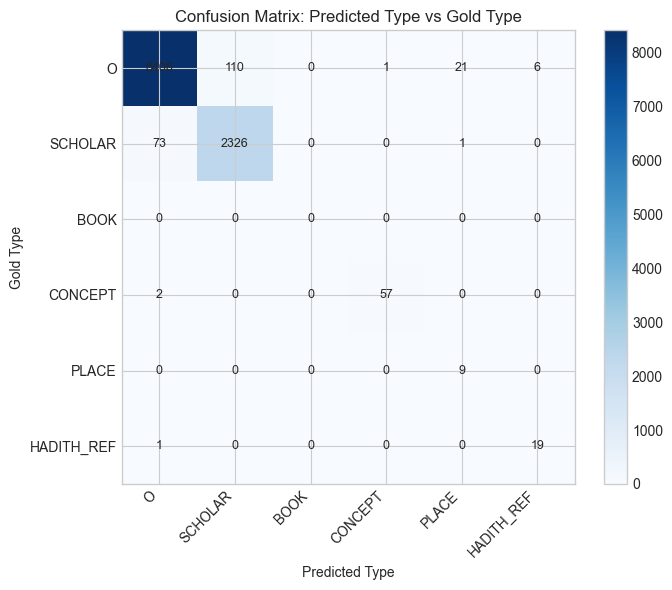

In [12]:
# Step 7 (viz 1): Confusion matrix (predicted type vs gold type).
flat_gold_types = [tag_to_type(tag) for seq in gold_out["y_true"] for tag in seq]
flat_pred_types = [tag_to_type(tag) for seq in gold_out["y_pred"] for tag in seq]

type_labels = ["O", *ENTITY_TYPES]
cm = pd.crosstab(
    pd.Categorical(flat_gold_types, categories=type_labels),
    pd.Categorical(flat_pred_types, categories=type_labels),
    dropna=False,
)
cm.index.name = "Gold"
cm.columns.name = "Predicted"

print("Confusion matrix table:")
display(cm)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm.values, cmap="Blues")
ax.set_xticks(np.arange(len(type_labels)))
ax.set_yticks(np.arange(len(type_labels)))
ax.set_xticklabels(type_labels, rotation=45, ha="right")
ax.set_yticklabels(type_labels)
ax.set_xlabel("Predicted Type")
ax.set_ylabel("Gold Type")
ax.set_title("Confusion Matrix: Predicted Type vs Gold Type")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = int(cm.iat[i, j])
        ax.text(j, i, str(val), ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


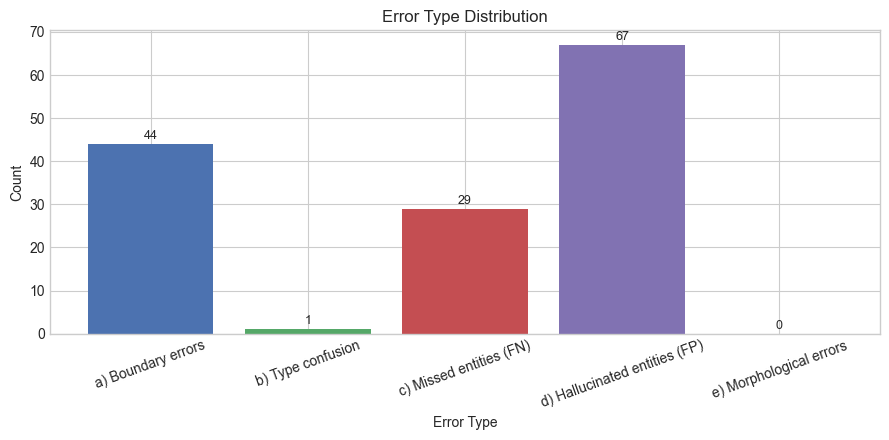

In [13]:
# Step 7 (viz 2): Error type distribution.
plot_df = summary_df.copy()

fig, ax = plt.subplots(figsize=(9, 4.5))
ax.bar(plot_df["Error Type"], plot_df["Count"], color=["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"])
ax.set_title("Error Type Distribution")
ax.set_ylabel("Count")
ax.set_xlabel("Error Type")
ax.tick_params(axis="x", rotation=20)

for i, val in enumerate(plot_df["Count"]):
    ax.text(i, val + 0.5, str(int(val)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


## Notes

- `BOOK` support can be zero depending on the sampled gold set; in that case BOOK F1 is not informative.
- Morphological category is assigned when Arabic diacritic/agglutination heuristics trigger.
- Boundary/type errors are paired by overlap (greedy best-overlap matching) for practical error review.
